In [121]:
#|default_exp training

In [122]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [123]:
mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data / 'mnist.pkl.gz'

In [124]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [125]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

# Initial Setup

## Data

In [126]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [127]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [128]:
model = Model(m, nh, 10)
preds = model(x_train)
preds

tensor([[-0.02,  0.18, -0.00,  ...,  0.10, -0.07,  0.06],
        [ 0.01,  0.10,  0.03,  ...,  0.02,  0.00,  0.05],
        [-0.03,  0.11,  0.02,  ...,  0.02,  0.03,  0.00],
        ...,
        [-0.02,  0.08,  0.07,  ...,  0.14, -0.01,  0.04],
        [-0.00,  0.10,  0.01,  ..., -0.03, -0.02,  0.05],
        [-0.07,  0.09,  0.10,  ...,  0.18, -0.07,  0.05]], grad_fn=<AddmmBackward0>)

In [129]:
preds.shape

torch.Size([50000, 10])

## Cross Entropy Loss

In [130]:
def logsoftmax(x): return x - x.exp().sum(-1, keepdim=True).log()

In [131]:
logsoftmax(preds)

tensor([[-2.33, -2.14, -2.32,  ..., -2.22, -2.38, -2.25],
        [-2.30, -2.21, -2.28,  ..., -2.29, -2.30, -2.26],
        [-2.34, -2.21, -2.30,  ..., -2.30, -2.29, -2.31],
        ...,
        [-2.34, -2.23, -2.25,  ..., -2.18, -2.33, -2.28],
        [-2.31, -2.20, -2.30,  ..., -2.33, -2.33, -2.26],
        [-2.38, -2.23, -2.21,  ..., -2.14, -2.39, -2.27]], grad_fn=<SubBackward0>)

In [132]:
def logsumexp(x):
    x = x.max(-1)[0]
    return m + (x - m[:, None]).exp().sum(-1).log()

In [133]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [134]:
sm_pred = log_softmax(preds)
sm_pred


tensor([[-2.33, -2.14, -2.32,  ..., -2.22, -2.38, -2.25],
        [-2.30, -2.21, -2.28,  ..., -2.29, -2.30, -2.26],
        [-2.34, -2.21, -2.30,  ..., -2.30, -2.29, -2.31],
        ...,
        [-2.34, -2.23, -2.25,  ..., -2.18, -2.33, -2.28],
        [-2.31, -2.20, -2.30,  ..., -2.33, -2.33, -2.26],
        [-2.38, -2.23, -2.21,  ..., -2.14, -2.39, -2.27]], grad_fn=<SubBackward0>)

Integer array indexing

- allows selection of items in an array based on their N-dimensional index.

In [135]:
y_train[:3]

tensor([5, 0, 4])

In [136]:
sm_pred[0,5], sm_pred[1, 0], sm_pred[2, 4]

(tensor(-2.43, grad_fn=<SelectBackward0>),
 tensor(-2.30, grad_fn=<SelectBackward0>),
 tensor(-2.31, grad_fn=<SelectBackward0>))

In [137]:
sm_pred[[0, 1, 2], y_train[:3]]

tensor([-2.43, -2.30, -2.31], grad_fn=<IndexBackward0>)

In [138]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [139]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

In Pytorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`

In [140]:
F.cross_entropy(preds, y_train)

tensor(2.30, grad_fn=<NllLossBackward0>)

## Basic Training Loop

A training loop repeats over the following steps:
- get the output of the model on a batch of input.
- compare the output to the labels we have and compute the loss.
- calculate the gradients of the loss with respect to every parameter of the model.
- update said parameters with those gradients to make them a little bit better.

In [141]:
loss_func = F.cross_entropy

In [142]:
bs = 50

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.02,  0.18, -0.00, -0.00, -0.08, -0.11,  0.03,  0.10, -0.07,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [143]:
yb = y_train[:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7,
        6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3])

In [144]:
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [145]:
preds.argmax(dim=1)

tensor([1, 1, 1, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 2, 2, 7, 1, 7, 7, 2, 7, 1, 7, 1, 1, 7, 4, 1, 7, 7, 1, 7, 1, 9, 0, 1, 1,
        1, 7, 1, 9, 1, 7, 7, 1, 1, 7, 1])

In [146]:
#|export
def accuracy(out, yb): return (out.argmax(dim=1) == yb).float().mean()

In [147]:
accuracy(preds, yb)

tensor(0.06)

In [148]:
lr = 0.5
epochs = 3

In [149]:
#|export
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [150]:
xb, yb = x_train[:bs], y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.30, 0.06


In [151]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(loss, preds, yb)

0.13, 0.96


0.12, 0.96
0.10, 0.96


# Using Parameters and optim

## Parameters

In [152]:
m1 = nn.Module()
m1.foo = nn.Linear(3, 4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [153]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [154]:
m1.named_children()

<generator object Module.named_children at 0x7f4ae8e0feb0>

In [155]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.29,  0.26,  0.15],
         [ 0.50, -0.18, -0.24],
         [-0.22,  0.07, -0.33],
         [ 0.10,  0.02,  0.29]], requires_grad=True),
 Parameter containing:
 tensor([-0.40,  0.30, -0.39,  0.19], requires_grad=True)]

In [156]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
        
    def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [157]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [158]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [159]:
for name, l in model.named_children(): print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [160]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [161]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n, i+bs))
            xb, yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [162]:
fit()

0.13, 0.96
0.14, 0.94
0.15, 0.92


In [163]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith('_'): self._modules[k] = v
        super().__setattr__(k, v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values(): yield from l.parameters()

#### MyModule class

`__init__` Method:
- `self._modules` is a dict used to store references to the submodules with `MyModule`.
- `self.l1` and `self.l2` are instances of the linear layers of the neural network.

`__setattr__` Method:
- it is overridden to customize attribute assignment behaviour. Whenever an attribute is set on an instance of `MyModule`, this method is called.
- Here, it stores the assigned attribute('v') in the '_modules' dict if the attribute name('k') doesn't start with an '_'.
- it then calls the parent class's `__setattr__` method to perform the actual assignment.

`parameters` Method:
- It iterates over the valies of the '_modules' dict and yields the parameters of each submodule using the 'parameters()' method.
- The 'yield from' statement allows the generator to yield directly from the nested generator produced by 'l.parameters'.

In [164]:
mdl = MyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [165]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


## Registering modules

In [166]:
from functools import reduce

In [167]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [168]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def forward(self, x): return reduce(lambda val, layer: layer(val), self.layers, x)

#### Model(nn.Module)

`__init__` method:
- For each layer, it adds the layer as a submodule to the `Model` using `self.add_module(f'layer_{i}', l)`. This allows the layer to be recognized and handles properly by PyTorch.

`forward` method:
- defines the forward pass computations of the `Model` and takes an input tensor `x` as the input.
- It used the `reduce` function to iteratively apply the layers to the input tensor `x`.
- For each layer in `self.layers`, it applies the layer to the current value(`val`) using the lambda function `lambda val, layer: layer(val)`.
- The output of each layer becomes the input to the next layer in the iteration.
- The final output of the forward pass is returned.

In [169]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [170]:
model(xb).shape

torch.Size([50, 10])

## nn.ModuleList

In [171]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [172]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [173]:
fit()

0.22, 0.94
0.15, 0.94
0.09, 0.96


## nn.Sequential

In [174]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [175]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.16, 0.92
0.10, 0.96
0.06, 0.98


(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

In [176]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## optim

In [177]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params, self.lr = list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr
    
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [178]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [179]:
opt = Optimizer(model.parameters())

In [180]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.13, 0.96
0.05, 1.00
0.04, 1.00


In [181]:
from torch import optim

In [182]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [183]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [184]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.10, 0.96
0.04, 0.98
0.03, 0.98


# Dataset and DataLoader

## Dataset

In [185]:
#|export
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [186]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [187]:
xb, yb = train_ds[:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [188]:
model, opt = get_model()

In [189]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb, yb = train_ds[i:min(n, i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.08, 0.98
0.08, 0.96
0.04, 1.00


## DataLoader

In [190]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i + self.bs]

In [191]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [192]:
xb, yb = next(iter(valid_dl))
xb.shape

torch.Size([50, 784])

In [193]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7,
        6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4])

tensor(3)

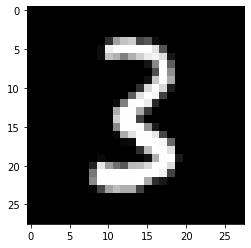

In [194]:
plt.imshow(xb[0].view(28, 28))
yb[0]

In [195]:
model, opt = get_model()

In [196]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        report(loss, preds, yb)

In [197]:
fit()

0.10, 0.98
0.04, 1.00
0.03, 1.00


In [198]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(1.))

## Random Sampling

In [199]:
import random

In [200]:
class Sampler():
    def __init__(self, ds, shuffle=False): self.n, self.shuffle = len(ds), shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [201]:
from itertools import islice

In [202]:
ss = Sampler(train_ds)

In [203]:
it = iter(ss)
for o in range(5): print(next(it))

0
1
2
3
4


In [204]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [205]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[21718, 35334, 43755, 11169, 12834]

In [206]:
import fastcore.all as fc

In [207]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

#### BatchSampler()

`__init__` method:
- it takes argument: `sampler`, which is the underlying sampler object used to sampler elements for each batch; `bs`, batch size; `drop_last`, boolean flag indicating whether to drop last batch if it is smaller than the specified batch size
- `fc.store_attr` is a shorthand way of providing arguments as instance attributes of the `BatchSampler` object.

`__iter__` method:
- it calls the `fc.chunked` function to chunk the iterator into batches.
- `fc.chunked` takes the arguments: `iter(self.sampler)` iterator to create batches from; `self.bs`, specifying number of elements per batch; `drop_last` indicating whether to drop the last batch.
- `yield from` is used to yield each batch from the iterator, effectively yielding batches of samples.

In [208]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[35895, 44866, 45366, 3883],
 [14679, 22822, 2491, 33218],
 [25132, 2325, 16592, 32899],
 [27694, 11020, 49632, 12300],
 [41257, 31857, 36464, 36312]]

In [209]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [210]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [211]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [212]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

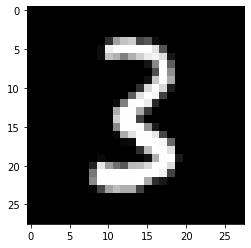

In [213]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

In [214]:
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [215]:
model, opt = get_model()

In [216]:
fit()

0.22, 0.92
0.11, 0.94
0.04, 0.98


## Multiprocessing DataLoader

In [217]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [218]:
train_ds[[3, 6, 8, 1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [219]:
train_ds.__getitem__([3, 6, 8, 1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [220]:
train_ds.__getitem__([3, 6, 8, 1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [221]:
for o in map(train_ds.__getitem__, ([3,6], [8, 1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [222]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

`__iter__` method of DataLoader:
- it creates a `mp.Pool` object with `self.n_workers` worker processes using the `with` statement. `mp.Pool` is used to parallelize the data loading process.
- `ex.map` function is used to apply the `self.ds.__getitem__` method to each item in the iterable `iter(self.batchs)`.
    - `self.ds` is the dataset object.
    - `self.ds.__getitem__` is called for each item in `item(self.bacths)`, which returns the corresponding data sample.
    - `ex.map` function applies this mapping operation in parallel using the worker processes in the pool
- `yield from` is used to yield each data sample obtained from `ex.map`.

In [223]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [224]:
# xb, yb = next(it)
# xb.shape, yb.shape

## PyTorch DataLoader

In [225]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [226]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [227]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [228]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.11, 0.96
0.08, 0.98
0.09, 0.96


(tensor(0.07, grad_fn=<NllLossBackward0>), tensor(0.98))

In [229]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [230]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [231]:
model, opt = get_model()
fit()

0.32, 0.94
0.06, 0.96
0.10, 0.98


In [232]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.06, grad_fn=<NllLossBackward0>), tensor(0.98))

In [233]:
train_ds[[4, 6, 7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

In [234]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [235]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

# Validation

In [236]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc, count = 0., 0., 0
            for xb, yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, yb).item() * n
                tot_acc += accuracy(pred, yb).item() * n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [237]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [238]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt  = get_model()

In [239]:
%time loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.15788114307448267 0.954900004863739
1 0.1219491614936851 0.9649000054597855
2 0.13140216656960546 0.9611000043153762
3 0.11675924166105688 0.9655000066757202
4 0.09959650813834742 0.9723000091314316
CPU times: user 5min 30s, sys: 7.27 s, total: 5min 37s
Wall time: 1min 26s


In [240]:
import nbdev
nbdev.nbdev_export()